In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
from ipywidgets import *

import numpy as np
from metric_spaces import MetricData
from metric_spaces.sphere import Sphere, r2_to_angle
from metric_spaces.euclidian import Euclidian
from regression.frechet_regression import LocalFrechet, GlobalFrechet
from regression.kernels import epanechnikov, gaussian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
M = Euclidian(1)
m = lambda x: 5 + 5*x[:,0]**2 + np.sin(20 * x[:,0]) - 10*x[:,0]**3 

def gen_data(N, eps=0.1):
    x = np.random.rand(N*1).reshape((N,1))

    theta = m(x) + eps*np.random.randn(N)
    return x, MetricData(M, theta.reshape((N,1)))
#     y = np.c_[np.cos(theta), np.sin(theta)]
#     return x, MetricData(M, y)

N = 200; eps = 0.5
x_train, y_train = gen_data(N, eps)
x_test, y_test = gen_data(100, eps)

for bw in [0.001, 0.005, 0.01, 0.02]:
# for bw in [0.005, 0.01, 0.02]:
    local_frechet = LocalFrechet(gaussian, bw).fit(x_train, y_train)
    preds = local_frechet.predict(x_test)
    errs = M.d(y_test, preds)**2
    print(bw, errs[~np.isnan(errs)].mean(), np.isnan(errs).sum())
    
# fr_angles = r2_to_angle(preds.data)
# theta_test = r2_to_angle(y_test.data)

# plt.scatter(x_test, theta_test, c='red',s=1,label="Y_i")
# plt.scatter(x_test, fr_angles, c='green',s=1,label="\\hat Y_i (local)")
# plt.plot(np.linspace(0,1,100), m(np.linspace(0,1,100).reshape((100,1))), c='black', linestyle='--', label='m(x)', alpha=0.1)
# plt.legend()

0.001 1828.2849750408473 0
0.005 30.347757572640656 0
0.01 7.525481003224857 0
0.02 39.84659306097194 0


In [46]:
global_fr = GlobalFrechet().fit(x_train, y_train)

preds = global_fr.predict(x_test)
errs = M.d(y_test, preds)**2

errs.mean()

1.4777073728062866

In [47]:
from regression.forests import RandomForest 
from regression.trees import MedoidTree

y_train.compute_distances()
forest = RandomForest(MedoidTree(), 500, 0.75).fit(x_train, y_train)

preds = forest.predict(x_test)
errs = M.d(y_test, preds)**2

errs.mean()

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:   25.9s finished


0.2959713627167235

In [50]:
from regression.nadaraya_watson import NadarayaWatson
from regression.kernels import epanechnikov, gaussian

# for bw in [0.002, 0.004, 0.005, 0.006, 0.008, 0.01]:
# for bw in [0.002, 0.004, 0.005, 0.006, 0.008, 0.01]:
for bw in [0.0005, 0.001, 0.005, 0.01, 0.02]:
    nw = NadarayaWatson(gaussian, bw=bw).fit(x_train, y_train)
    preds = nw.predict(x_test)
    errs = Sphere(1).d(y_test, preds)**2
    print(bw, errs[~np.isnan(errs)].mean(), np.isnan(errs).sum())


0.0005 1.8415966224724576 96
0.001 1.8703192554728534 96
0.005 1.5945100703862107 95
0.01 2.0927977209740187 96
0.02 2.7829563490923186 97


/Users/matthieubulte/Documents/university/phd/merf/metric_spaces/sphere.py:14: RuntimeWarning: invalid value encountered in arccos
  return np.sum(np.square(np.arccos(np.dot(x,y.T))), axis=0)


<IPython.core.display.Javascript object>


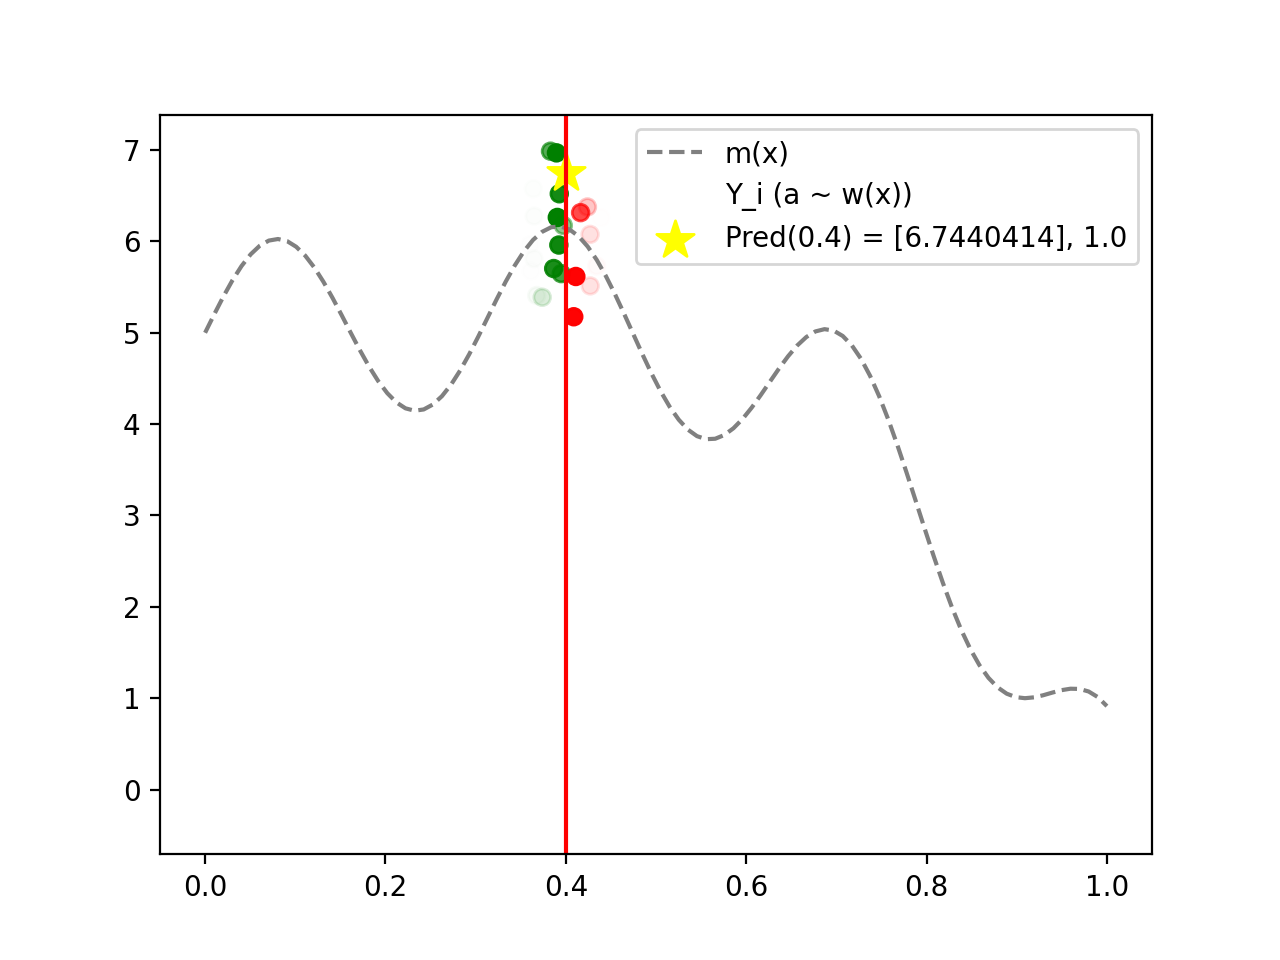

interactive(children=(FloatSlider(value=0.5, description='_x', max=1.5, min=-0.5), Output()), _dom_classes=('w…

In [52]:
%matplotlib notebook

est = LocalFrechet(gaussian, 0.01).fit(x_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
weights = est.weights_for([0.5])

ax.plot(np.linspace(0,1,100), m(np.linspace(0,1,100).reshape((100,1))), c='gray', linestyle='--', label='m(x)')
scat = ax.scatter(x_train, y_train.data, label='Y_i (a ~ w(x))')

eval_pt = ax.axvline(0.5, c='red')

pred_val = est.predict(np.array([0.5]))
pred_scat = ax.scatter([0.5], pred_val, marker='*', color='yellow', s=200, label=f'Pred(x) = {pred_val}')

ax.legend()

def update(_x = 0.5):
    weights = est.weights_for([_x])
    pred_val = est.predict(np.array([_x]))

    scat.set_alpha(np.abs(weights) / np.max(np.abs(weights)))
    scat.set_color(np.array(['red', 'green'])[0+(weights > 0)])
    
    eval_pt.set_xdata(_x)
    pred_scat.set_offsets([[_x, pred_val[0]]])
    pred_scat.set_label(f'Pred({_x}) = {pred_val}, {weights.sum()}')
    ax.legend()
    fig.canvas.draw_idle()

interact(update);

In [30]:
est.weights_for([0.4]).min()

0.0

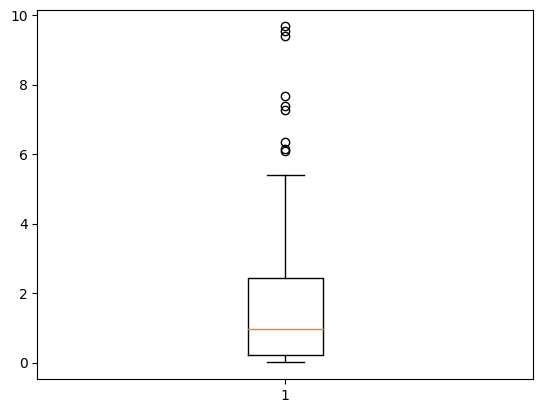

In [55]:
%matplotlib inline
plt.boxplot(errs[~np.isnan(errs)]);